# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer
import folium

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
350              Data Scientist/Lead Data Scientist - LA   
7605                    Software Design Support Engineer   
9177                            Business Analyst Level-1   
2685                         SAP Data Analyst (Contract)   
6941                                       Data Engineer   
11097                           Business Systems Analyst   
7554                            Product Systems Engineer   
4303   Senior Data Analytics Solutions Analyst with S...   
5938                          Lead Data Analyst, Product   
6680                            Senior Big Data Engineer   

                                         Job Description  \
350    Lead Data Scientist\n\nData Scientists and Lea...   
7605   Company:\nQualcomm Technologies, Inc.\nJob Are...   
9177   Job Description\nJob Summary:\nLooking for hig...   
2685   Please find the full job description below and...   
6941   Do you want your voice heard and your actions ...   
11097  Hello Associates,\n\n*****Greetings from Conch...   
7554   TrellisWare Technologies, Inc. is developing a...   
4303   Praescient Analytics, LLC (Praescient) is a Ve...   
5938   Chime is the largest and fastest-growing playe...   
6680   Analytics\nSenior Big Data Engineer - QuantumB...   

                           Company Name           Location           City  \
350                            BlueLabs    Los Angeles, CA    Los Angeles   
7605                           Qualcomm      San Diego, CA      San Diego   
9177   Staffigo Technical Services, LLC    Los Angeles, CA    Los Angeles   
2685           Two95 International Inc.         Irving, TX         Irving   
6941                               MUFG          Tempe, AZ          Tempe   
11097           Conch Technologies, Inc      San Diego, CA      San Diego   
7554      TrellisWare Technologies, Inc      San Diego, CA      San Diego   
4303               Praescient Analytics       New York, NY       New York   
5938                              Chime  San Francisco, CA  San Francisco   
6680                       QuantumBlack        Chicago, IL        Chicago   

      State     Remote          Size  Founded                     Industry  \
350      CA  Uncertain    Very Small      NaN         Research Development   
7605     CA  Uncertain    Very Large   1985.0   Computer Hardware Software   
9177     CA  Uncertain         Small   2008.0                  IT Services   
2685     TX  Uncertain    Very Small      NaN         Staffing Outsourcing   
6941     AZ  Uncertain    Very Large   1864.0          Banks Credit Unions   
11097    CA  Uncertain         Small      NaN                   Consulting   
7554     CA  Uncertain         Small   2000.0  Telecommunications Services   
4303     NY  Uncertain         Small   2011.0                   Consulting   
5938     CA  Uncertain  Medium-Small   2013.0          Banks Credit Unions   
6680     IL  Uncertain        Medium   2009.0                   Consulting   

       Rating  SalaryMin  SalaryMax  Salary Estimate   DF  
350       4.7        102        164            133.0  DF1  
7605      4.0         46         92             69.0  DF1  
9177      5.0         63         79             71.0  DF1  
2685      4.0         85        147            116.0  DF1  
6941      3.1         69        122             95.5  DF1  
11097     4.6         81         97             89.0  DF1  
7554      3.6         77        181            129.0  DF1  
4303      3.1         48         96             72.0  DF1  
5938      4.8         47         74             60.5  DF1  
6680      3.8         67         72             69.5  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
2492                                     Data Scientist   
2581  Principal Data Scientist-- Ensemble Algorithms...   
3334               Medical Lab Scientist (MLS) Evenings   
198                            Scientist Data Analytics   
1205                               Data Science Manager   
3684                                Senior Data Analyst   
46                                       Data Scientist   
1768  Hadoop Developer / Data Engineer / Bigdata Eng...   
1936               Pharmaceutical Customer Data Analyst   
229     Senior Data Scientist, Treasury Product Manager   

                                        Job Description  \
2492  HMS makes the healthcare system work better fo...   
2581  Principal Data Scientist-- Ensemble Algorithms...   
3334  We Are Hiring\n\nMedical Lab Scientist (MLS) -...   
198   Title: Scientist Data Analytics\nJob ID: BM765...   
1205  a.dialogApplyBtn {\ndisplay: none;\n}\n\n\n\nD...   
3684  As a Senior Data Analyst at the full performan...   
46    Looking for a job to get you out of bed?Casper...   
1768  Hadoop Developer Data Engineer Bigdata Enginee...   
1936  Duration: 6 months contract\n\nResponsibilitie...   
229   Job Description:\n\nJOB DESCRIPTION\n\nGlobal ...   

                           Company Name              Location  \
2492                                HMS            Irving, TX   
2581                     Ava Consulting            Dallas, TX   
3334                          Ascension            Austin, TX   
198                               TEEMA          New York, NY   
1205                     LyondellBasell           Houston, TX   
3684                           Ho Chunk         Arlington, TX   
46                               Casper          New York, NY   
1768  Digital Intelligence Systems, LLC      Philadelphia, PA   
1936         APN Software Services Inc.  Plymouth Meeting, PA   
229                     Bank of America          New York, NY   

                  City State     Remote          Size  Founded  \
2492            Irving    TX  Uncertain    Very Small      NaN   
2581            Dallas    TX  Uncertain    Very Small      NaN   
3334            Austin    TX  Uncertain    Very Large   1999.0   
198           New York    NY  Uncertain  Medium-Small   2008.0   
1205           Houston    TX  Uncertain    Very Large   2007.0   
3684         Arlington    TX        Yes  Medium-Small   1995.0   
46            New York    NY  Uncertain        Medium   2014.0   
1768      Philadelphia    PA  Uncertain  Medium-Large   1994.0   
1936  Plymouth Meeting    PA  Uncertain         Small      NaN   
229           New York    NY  Uncertain    Very Large   1904.0   

                                Industry  Rating SalaryMin SalaryMax  \
2492                                 NaN     3.5        12      112    
2581                         IT Services     4.4        49       78    
3334    Health Care Services & Hospitals     3.3        38       68    
198               Staffing & Outsourcing     4.7       119      147    
1205              Chemical Manufacturing     3.7       138      217    
3684    Convenience Stores & Truck Stops     2.8        55       98    
46    Home Furniture & Housewares Stores     3.4       120      140    
1768                         IT Services     3.4        65      100    
1936        Computer Hardware & Software     4.1        55      101    
229                Banks & Credit Unions     3.7       116      152    

      Salary Estimate   DF  
2492              NaN  DF2  
2581              NaN  DF2  
3334              NaN  DF2  
198               NaN  DF2  
1205              NaN  DF2  
3684              NaN  DF2  
46                NaN  DF2  
1768              NaN  DF2  
1936              NaN  DF2  
229               NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
807                                 Research Scientist   
723   Scientist - Oligonucleotide Chemical Development   
871                                     data scientist   
745              Data Scientist - Capacity Engineering   
533                      Research Data Project Manager   
529                                  Big Data Engineer   
740                                     Data Scientist   
144  Research Scientist or Senior Research Scientis...   
220                Environmental Scientist in Training   
587                                     Data Scientist   
381                                     Data Scientist   
341                                Lead Data Scientist   
867                                     Data Scientist   
581                                     Data Scientist   
31   Sr Scientist/Sr Engineer Technical Transfer - ...   
173                              Senior Data Scientist   
712                                     Data Scientist   
785                    Data Engineer (Multiple Levels)   
626                                     Data Scientist   
848                                     Data Scientist   

                                       Job Description  \
807  About Concerto HealthAI\n\nConcerto HealthAI i...   
723  Dicerna Pharmaceuticals is seeking highly moti...   
871  Description\nCognistx is looking to hire an ex...   
745  By applying for this role, you could choose to...   
533  Hawkins Point is seeking a Senior Project Mana...   
529  We are looking for strong Big Data Engineers a...   
740  Our Houston Research Center focuses on researc...   
144  25 years of innovation\n\nThe Computer Vision ...   
220  Join us as we Rise to the Challenge\nAt KCI, w...   
587  Data Scientist\nLocation\n\n\nTysons Corner, V...   
381  Use statistical analysis, machine learning, pa...   
341  Lead Data Scientist\n\nZynga is a leading deve...   
867  Join a thriving company that is changing the w...   
581  Descript is a new kind of audio/video creation...   
31   Company Overview\n\nTranslate Bio is a leading...   
173  Location: San Francisco, CA- United States\nJo...   
712  Job\nSummary\nApply several forms of statistic...   
785  Purpose of Job\nWe are currently seeking talen...   
626  our client's Data Science and ML team as a ful...   
848  Hello Denver! We are excited to be here!\nSnap...   

                          Company Name           Location           City  \
807                  Concerto HealthAI             Remote            NaN   
723                            Dicerna        Boulder, CO        Boulder   
871                           Cognistx     Pittsburgh, PA     Pittsburgh   
745                            Twitter             Remote            NaN   
533               HawkinsPointPartners      Cambridge, MA      Cambridge   
529         Meridian Technologies, Inc        Seattle, WA        Seattle   
740            Aramco Services Company        Houston, TX        Houston   
144  Mitsubishi Electric Research Labs      Cambridge, MA      Cambridge   
220                   KCI Technologies   Indianapolis, IN   Indianapolis   
587            Ridgeline International         Tysons, VA         Tysons   
381            Lorven Technologies Inc       New York, NY       New York   
341                              Zynga         Austin, TX         Austin   
867                         AccessHope      Irwindale, CA      Irwindale   
581                           Descript  San Francisco, CA  San Francisco   
31                       Translate Bio      Lexington, MA      Lexington   
173                           Autodesk  San Francisco, CA  San Francisco   
712               Associated Banc-Corp      Milwaukee, WI      Milwaukee   
785                               USAA          Plano, TX          Plano   
626                        RampUp, Inc         Denver, CO         Denver   
848                     Snapdocs, Inc.         Denver, CO         Denver   

    State 

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
1041                          Senior Data Analyst   
1648                                 Data Analyst   
1319                     Data Analyst BHJOB11946_   
1017     Data Modeler / Analyst with Data Steward   
1178                         Sport & Data Analyst   
1021                        CLINICAL DATA ANALYST   
735                                  Data Analyst   
299   Data Analyst II - Division of Endocrinology   
1863              Marketing Data Analyst - Remote   
21                           Data Science Analyst   

                                        Job Description  \
1041  Job Description\nJob Summary:\n\nAs a Senior D...   
1648  The Data Analyst serves as a resource for busi...   
1319  Job Title Data Analyst As a validation analyst...   
1017  Job Description\nMUST HAVES:\n• Knowledge of b...   
1178  Founded by Josh Harris and David Blitzer, Harr...   
1021  Envision Physician Services is a multispecialt...   
735   Job Description\nPossible Contract to Hire!\n\...   
299   Strength Through DiversityGround breaking scie...   
1863  Software Guidance & Assistance, Inc., (SGA), i...   
21    Job Description\nOur client, a music streaming...   

                    Company Name           Location           City State  \
1041           Pure Flix Digital     Scottsdale, AZ     Scottsdale    AZ   
1648              Central Health         Austin, TX         Austin    TX   
1319               Addison Group         Dallas, TX         Dallas    TX   
1017           Strategic Systems          Tempe, AZ          Tempe    AZ   
1178   Philadelphia 76ers - HBSE         Camden, NJ         Camden    NJ   
1021         Envision Healthcare        Phoenix, AZ        Phoenix    AZ   
735                        Swoon  Downers Grove, IL  Downers Grove    IL   
299   Mount Sinai Medical Center       New York, NY       New York    NY   
1863                    SGA Inc.      Charlotte, NC      Charlotte    NC   
21         MUSIC & Entertainment       New York, NY       New York    NY   

         Remote          Size  Founded                              Industry  \
1041  Uncertain           NaN      NaN                                   NaN   
1648  Uncertain         Small      NaN      Health Care Services & Hospitals   
1319  Uncertain        Medium   1999.0                Staffing & Outsourcing   
1017  Uncertain  Medium-Small   2004.0                           IT Services   
1178        Yes           NaN      NaN                                   NaN   
1021  Uncertain    Very Large   2005.0      Health Care Services & Hospitals   
735   Uncertain  Medium-Small   2010.0                Staffing & Outsourcing   
299   Uncertain  Medium-Large   1946.0      Health Care Services & Hospitals   
1863        Yes    Very Small   1996.0  Architectural & Engineering Services   
21          Yes           NaN      NaN                                   NaN   

      Rating SalaryMin SalaryMax  Salary Estimate  DF  
1041     NaN        43       94               NaN  DA  
1648     3.6        42       76               NaN  DA  
1319     3.3        24       48               NaN  DA  
1017     4.5        46      102               NaN  DA  
1178     NaN        64      113               NaN  DA  
1021     3.0        46      102               NaN  DA  
735      4.6        60       66               NaN  DA  
299      3.1        27       52               NaN  DA  
1863     NaN        53       99               NaN  DA  
21       NaN        37       66               NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
1338  Vehicle Test Engineer - Artificial Intelligenc...   
1422                    Software Engineer - Talent Pool   
1115                         First Flyer, Data Engineer   
152                           Data Architect & Engineer   
807                                Senior Data Engineer   
616               Data Engineer - Business Intelligence   
529        Future Opportunity: Senior Software Engineer   
954                                  Big Data Developer   
1492      Design Optimization Engineer (Staff or above)   
1688                                    Data Engineer 3   

                                        Job Description  \
1338  This position is located in El Paso, Texas. Yo...   
1422  Location: San Diego,California,United States\n...   
1115  Bachelor's degree (B.A or B.S) from four-year ...   
152   Koneksa Health is a health information technol...   
807   Our mission is to protect life.\nWe’re out to ...   
616   alliantgroup is currently in search of a full-...   
529   Company Description\n\n\nWe’ve all had a recru...   
954   Title : Big Data Engineer\n\nLocation : Phoeni...   
1492  Company:\nQualcomm Technologies, Inc.\nJob Are...   
1688  Note Candidate can start remotely and till COV...   

                    Company Name          Location          City State  \
1338                    TuSimple   San Antonio, TX   San Antonio    TX   
1422         Quartus Engineering     San Diego, CA     San Diego    CA   
1115            Freedom Mortgage  Mount Laurel, NJ  Mount Laurel    NJ   
152               Koneksa Health      New York, NY      New York    NY   
807                         Axon    Scottsdale, AZ    Scottsdale    AZ   
616             alliantgroup, LP       Houston, TX       Houston    TX   
529                        Yello       Chicago, IL       Chicago    IL   
954   Youth Power Technosoft LLC       Phoenix, AZ       Phoenix    AZ   
1492                    Qualcomm     San Diego, CA     San Diego    CA   
1688            cyberThink, Inc.         Plano, TX         Plano    TX   

         Remote          Size  Founded  \
1338  Uncertain  Medium-Small   2015.0   
1422  Uncertain         Small   1997.0   
1115  Uncertain  Medium-Large   1990.0   
152         Yes           NaN      NaN   
807   Uncertain  Medium-Large   1991.0   
616   Uncertain        Medium   2001.0   
529   Uncertain         Small   2008.0   
954   Uncertain           NaN      NaN   
1492  Uncertain    Very Large   1985.0   
1688        Yes  Medium-Small   1996.0   

                                     Industry  Rating SalaryMin SalaryMax  \
1338             Computer Hardware & Software     3.6        67      107    
1422     Architectural & Engineering Services     4.6        77      181    
1115    Investment Banking & Asset Management     4.3        54      104    
152                                       NaN     NaN        57       75    
807              Computer Hardware & Software     3.7        69      122    
616                                Consulting     3.4        94      107    
529   Enterprise Software & Network Solutions     3.6        67       72    
954                                       NaN     NaN        74      145    
1492             Computer Hardware & Software     4.0        79      132    
1688                              IT Services     3.6       105      110    

      Salary Estimate  DF  
1338              NaN  DE  
1422              NaN  DE  
1115              NaN  DE  
152               NaN  DE  
807               NaN  DE  
616               NaN  DE  
529               NaN  DE  
954               NaN  DE  
1492              NaN  DE  
1688              NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
35              Scientific Data Analyst   
278                      Data Scientist   
126                      Data Scientist   
579                   AWS Data Engineer   
390   Data Analyst - Advanced Analytics   
520  Sr. Data Engineer (Data Warehouse)   
706   Intern - Analytics & Data Science   
762                 Senior Data Analyst   
39                      Data Analyst II   
54                       Data Scientist   

                                       Job Description           Company Name  \
35   Scientific Data Analyst\n\nMelbourne, FL\n\nAb...            ENSCO, Inc.   
278  Facebook's mission is to give people the power...               Facebook   
126  Data Scientist, St. Louis, MO\n\n***No c2c or ...           Envision LLC   
579  AWS Data Engineer Northern, VA\n\nAWS Data Eng...       NuWave Solutions   
390  Want to work for a company that is reimagining...                 Univar   
520  The Opportunity\n\nWe are looking for cloud Sr...  Rodan and Fields, LLC   
706  Posting Title\nIntern - Analytics & Data Scien...         Solar Turbines   
762  Overview\n\n\nCompany Overview:\n\nGuided by a...        Ability Network   
39   Who is Cenlar?\n\nYou are.\n\nEmployee-owners ...                 Cenlar   
54   Company Description:\n\nQuartet is a pioneerin...         Quartet Health   

              Location           City State     Remote          Size  Founded  \
35       Melbourne, FL      Melbourne    FL  Uncertain        Medium   1969.0   
278        Fremont, CA        Fremont    CA  Uncertain    Very Large   2004.0   
126    Saint Louis, MO    Saint Louis    MO  Uncertain  Medium-Small   1994.0   
579      Arlington, VA      Arlington    VA  Uncertain         Small   1999.0   
390  Downers Grove, IL  Downers Grove    IL  Uncertain         Large   1924.0   
520  San Francisco, CA  San Francisco    CA  Uncertain        Medium   2002.0   
706      San Diego, CA      San Diego    CA        Yes         Large   1927.0   
762    Minneapolis, MN    Minneapolis    MN  Uncertain  Medium-Small   2000.0   
39           Ewing, NJ          Ewing    NJ  Uncertain  Medium-Large   1958.0   
54        New York, NY       New York    NY  Uncertain  Medium-Small   2014.0   

                                    Industry  Rating SalaryMin SalaryMax  \
35                       Aerospace & Defense     3.6        86      143    
278                                 Internet     4.6        97      150    
126                   Staffing & Outsourcing     4.5        59      101    
579                              IT Services     4.4        74      127    
390                                Wholesale     3.2        48       80    
520     Beauty & Personal Accessories Stores     2.4       120      170    
706                       Oil & Gas Services     3.7        79      138    
762             Computer Hardware & Software     2.9       109      153    
39                                       NaN     2.5        86      143    
54   Enterprise Software & Network Solutions     3.9        86      143    

     Salary Estimate  DF  
35               NaN  DS  
278              NaN  DS  
126              NaN  DS  
579              NaN  DS  
390              NaN  DS  
520              NaN  DS  
706              NaN  DS  
762              NaN  DS  
39               NaN  DS  
54               NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
14168                Data Engineer - Analytics Warehouse   
13833               Project Regulatory/Risk Data Analyst   
17321                        Data Engineer Developer (2)   
14413                                 Research Scientist   
3827                                   Big Data Engineer   
25986               Data Engineer Lead, Machine Learning   
5452                                        Data Analyst   
10873                          Clinical Outcomes Analyst   
11585                                       Data Analyst   
3066                           SystemC Modeling Engineer   
15889                Digital Signal Processing Scientist   
23770                                      Data engineer   
2850                                      Data Scientist   
9949                        Application Security Analyst   
19152                                     Data Scientist   
10667                                   Business Analyst   
18868                            Pricing and Bid Analyst   
24566                                  Database Engineer   
5729   Application Programmer V/ Database Developer/ ...   
24627                         Sr. DDI Migration Engineer   

                                         Job Description  \
14168  About gettacar:\n\ngettacar is a direct-to-you...   
13833  Project Regulatory/Risk Data Analyst\n\nApply ...   
17321  Solid hands experience on Big Data Technology ...   
14413  Laulima Government Solutions, LLC is looking f...   
3827   Qualifications:\n\nExperience developing enter...   
25986  BICP is partnered with an iconic retail client...   
5452   Quicken is committed to helping people lead he...   
10873  Clinical Outcomes Analyst\nLocation\n\n\nTX - ...   
11585  Nokia is a global leader in the technologies t...   
3066   Description\n\nAt Xilinx, we are leading the i...   
15889  Job Posting Title:\n\nDigital Signal Processin...   
23770        Data engineer heavy on Python, SQL and ETL.   
2850   Requisition ID: 255385\nWork Area: Software-Re...   
9949   Job Description\nPosition Summary:\n\nThis rol...   
19152  5+ years' experience in leading Analytics, Dat...   
10667  Job Description\nJob Title\nBusiness Analyst\n...   
18868  Review and maintain analysis of competitive ma...   
24566  Hello,\n\nÂ\n\nTitle: Database Engineer\n\nLoc...   
5729   Category: Other Area(s)\nLocation: Charlotte, ...   
24627  Sr. DDI Migration Engineer WFH\n[DNS/DHCP/IPAM...   

                                   Company Name              Location  \
14168                                  gettacar      Philadelphia, PA   
13833                                      MUFG             Tempe, AZ   
17321                                    Qwinix         Englewood, CO   
14413  Alaka`ina Foundation Family of Companies  Fort Sam Houston, TX   
3827                                  Cognizant          Columbus, OH   
25986                                      BICP        Fort Worth, TX   
5452          QUICKEN INVESTMENT SERVICES, INC.        Menlo Park, CA   
10873                      Alaka`ina Foundation       San Antonio, TX   
11585                                     Nokia            Dallas, TX   
3066                                     Xilinx          San Jose, CA   
15889             Applied Research Laboratories            Austin, TX   
23770                             Dataquad Inc.          New York, NY   
2850                                        SAP         Palo Alto, CA   
9949                                   Ion Idea           Houston, TX   
19152                      Course5 Intelligence           Seattle, WA   
10667                          KRG Technologies       San Antonio, TX   
18868                     American Regent, Inc.          Melville, NY   
24566                           Softcom Systems        Scottsdale, AZ   
5729                                  DATA Inc.         Charlotte, NC   
24627                        Efficient IP, Inc.      Philadelphia

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
# remote, part-time, temp, senior, and junior functions
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r
def junior(x):
    x=x.lower()
    if "junior" in x or "jr" in x:
        r=1
    else:
        r=np.nan
    return r

        

#Senior = x[16]
#sen= x[23]
FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))
FullDataSet['jun']=FullDataSet['Job Description'].dropna().apply(lambda x: junior(x))
FullDataSet['Senior'].fillna(FullDataSet['sen'], inplace=True)
FullDataSet['Junior'].fillna(FullDataSet['jun'], inplace=True)

In [14]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())
print(FullDataSet['Senior'].sum())
print(FullDataSet['Junior'].sum())

2441.0
393.0
1911.0
7239.0
1338.0


In [15]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/37 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### NLP

In [16]:
#dropping job duplicates with no salary coluumns
criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataSet
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

In [17]:
#! pip install contractions
#nltk.download('all')

In [18]:
#Removing contractions, punctuations, @, and lemmatizations
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        if "scala" == word:
            sentence.append('scala')
            continue
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 

# make new column for edited job description
FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7143     description lead participate design build mana...
8653     company overview memorial sloan kettering msk ...
                               ...                        
27040    great big data analytics security engineer fis...
27041    title data scientist springfield va term hire ...
27042    responsibility include support team developer ...
27043    continue impact covid 19 social distance measu...
27044    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16206, dtype: object

In [19]:
#remove common job description words
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    stat=r"(statistical)"
    x=re.sub(stat,"statistic",x)
    an=r"(analyze)"
    x=re.sub(an,"analytical",x)
    dl=r"(deep learn)"
    x=re.sub(bd,"bigdata",x)
    x=re.sub(dl,"deeplearning",x)
    ai=r"(artificial intelligence)"
    x=re.sub(ai,"ai",x)
    replaced=r'(\·|\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b|\badvance\b|\bandor\b|\bapply\b|\bcommunication\b|\bcomputer\b|\bcreate\b|\bdegree\b|\bdocument\b|\bemployee\b|\bemployment\b|\bensure\b|\benvironment\b|\bfunctional\b|\bhelp\b|\bidentify\b|\binsight\b|\blarge\b|\blead\b|\blearn\b|\blevel\b|\bmake\b|\bmanage\b|\bmarket\b|\bmay\b|\bmeet\b|\bmust\b|\boperation\b|\bperform\b|\bplan\b|\bprefer\b|\brelate\b|\breport\b|\brequirement\b|\bresponsibility\b|\bstatus\b|\btechnique\b|\btime\b|\buser\b|\bworld\b|\bwrite\b|\baccount\b|\bacross\b|\bassist\b|\bbest\b|\bcandidate\b|\bchange\b|\bcomplex\b|\bdecision\b|\bdetail\b|\bdisability\b|\bdocumentation\b|\beducation\b|\betc\b|\bexcellent\b|\bfield\b|\bhealth\b|\bhigh\b|\bimplement\b|\bimplementation\b|\bindustry\b|\bissue\b|\bmaintain\b|\bmultiple\b|\boffice\b|\borganization\b|\bpartner\b|\bpeople\b|\bperformance\b|\breview\b|\brisk\b|\bsecurity\b|\bsolve\b|\bsource\b|\bstakeholder\b|\btrain\b|\bu\b|\bwell\b|\bwithin\b|\b3\b|\b5\b|\bable\b|\bapplicant\b|\bbachelor\b|\bbenefit\b|\bcommunicate\b|\bdefine\b|\bdeliver\b|\bdemonstrate\b|\bend\b|\bequivalent\b|\bfunction\b|\bgather\b|\bimprove\b|\bimprovement\b|\bindividual\b|\binternal\b|\bkey\b|\blanguage\b|\blook\b|\bone\b|\bpay\b|\bpolicy\b|\bpractice\b|\bpredictive\b|\bprofessional\b|\bqualification\b|\bquantitative\b|\bresponsible\b|\bresult\b|\bsale\b|\bset\b|\b2\b|\bactivity\b|\barea\b|\bassign\b|\bcase\b|\bcomplete\b|\bdepartment\b|\bemployer\b|\bfederal\b|\bfocus\b|\bfollow\b|\blike\b|\blocation\b|\bmanager\b|\bmember\b|\boffer\b|\bplus\b|\bprocedure\b|\bspecification\b|\bstate\b|\bvalue\b|\bvarious\b|\bcareer\b|\bcompliance\b|\beffectively\b|\bfind\b|\bgroup\b|\bimpact\b|\blaw\b|\bminimum\b|\bmonitor\b|\boperational\b|\bparticipate\b|\bplease\b|\bprotect\b|\brequest\b|\bstaff\b|\bstandard\b|\bstrategy\b|\bveteran\b|\bgood\b|\baction\b|\bbank\b|\bcare\b|\bconduct\b|\bcontract\b|\bcost\b|\benterprise\b|\bglobal\b|\bhealthcare\b|\bmethodology\b|\bqualify\b|\bregard\b|\bresource\b|\bserve\b|\beg\b|\bmethod\b|\bexpertise\b|\bchallenge\b|\bgrow\b|\bapproach\b|\balso\b|\bagile\b|\bstory\b|\bcross\b|\bexist\b|\bcurrent\b|\bday\b|\bfull\b|\bpart\b|\binsurance\b|\breligion\b|\bcurrent\b|\b1\b|\bbi\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform   next gen...
7143                   scale   structure pipeline effic...
8653       overview memorial sloan kettering msk   way ...
                               ...                        
27040    great bigdata       fiserv passionate   want s...
27041    title     springfield va term hire     salary ...
27042          team developer       variety research   ...
27043    continue   covid 19 social distance measure ke...
27044        tssci poly clearance     tssci poly   mcle...
Name: edit_jobDescription, Length: 16206, dtype: object

In [20]:
#fix huge amount of different job title names
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 


#make new column with edited job title
FDSword['edit_jobTitle']=FDSword['Job Title'].dropna().apply(lambda x: fixTitle(x))
FDSword['edit_jobTitle']

1712        Data Engineer
2144       Data Scientist
3078       Data Scientist
7143        Data Engineer
8653     Business Analyst
               ...       
27040            Big Data
27041      Data Scientist
27042      Data Scientist
27043    Machine Learning
27044      Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [21]:
profileJT = pp.ProfileReport(FDSword.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profileJT

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
#used for testing
# from wordcloud import WordCloud
# #collocations=False
# test = pd.read_csv("test.csv")
# def fun(x):
#     if x is None:
#         return ""
#     wordList.append(x)
    
# jt=['Data Engineer']

# for job in jt:
#     wordList=[]
#     FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))  
#     abc=" ".join(wordList)
#     wordcloud = WordCloud().generate(abc)
#     # Display the generated image:      
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")
#     print(job)
#     plt.show()
#     testing=[w for w in abc.split() if 'scala' == w ]
#     print(len(testing))
#     words=pd.Series(abc.split())
#     print(words)
#     print(words.value_counts().sort_values(ascending=False).head(20))
    
#     print("\n")

Data Engineer


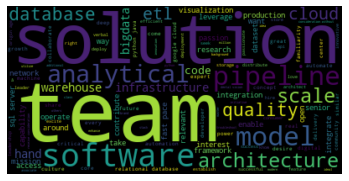



Data Scientist


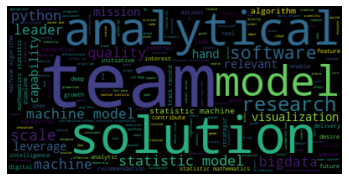



Business Analyst


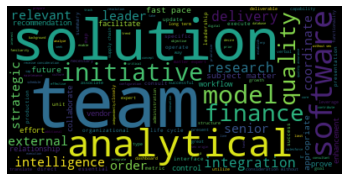



Analyst


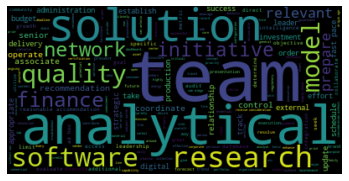



Data Analyst


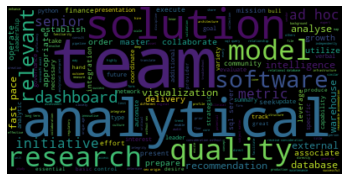

In [23]:
#job title word clouds
from wordcloud import WordCloud
#collocations=False
# filterList=[]
def fun(x):
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(job)
    plt.show()
#     words=pd.Series(abc.split())
#     print(f'Top 20 words for {job} are \n{words.value_counts().sort_values(ascending=False).head(20)}')
#     filterList.append(words.value_counts().sort_values(ascending=False).head(25))
    
    print("\n")

# print(filterList)
    

Top 20 words for Data Engineer are 
- team              4421
- solution          2543
- sql               1933
- pipeline          1911
- database          1775
- cloud             1701
- model             1624
- python            1574
- software          1552
- aws               1308
- warehouse         1280
- architecture      1149
- spark             1041
- etl               1036
- bigdata           1032
- quality            998
- infrastructure     950
- analytical         941
- stream             736
- scale              736

Top 20 words for Data Scientist are 
- team             8976
- model            7871
- statistic        5891
- machine          5127
- solution         3787
- analytical       3469
- research         3179
- python           2830
- algorithm        2138
- r                2012
- sql              1981
- software         1924
- visualization    1458
- ai               1441
- mathematics      1369
- mine             1154
- scale            1147
- collaborate      1139
- leadership       1120
- database         1112


Top 20 words for Business Analyst are 
- team            5851
- solution        4080
- analytical      2939
- software        1736
- quality         1111
- model           1046
- sql             1023
- excel            834
- initiative       833
- finance          805
- microsoft        758
- senior           735
- strategic        719
- delivery         692
- integration      691
- coordinate       684
- goal             682
- relationship     677
- collaborate      659
- salesforce       658

Top 20 words for Analyst are 
- team          2721
- analytical    1518
- solution      1230
- research       830
- model          803
- software       707
- quality        614
- finance        512
- excel          470
- microsoft      454
- statistic      438
- sql            432
- network        425
- control        410
- budget         398
- origin         395
- prepare        393
- initiative     380
- credit         371
- database       370

Top 20 words for Data Analyst are 
- team             6360
- analytical       4363
- sql              2822
- solution         2811
- quality          2764
- database         2440
- statistic        2425
- model            2172
- research         1669
- software         1468
- excel            1424
- visualization    1134
- microsoft        1121
- query            1088
- tableau          1011
- dashboard         998
- senior            941
- master            932
- python            929
- trend             924

In [24]:
#eliminate irrelevant job title info
FDSword = FDSword[FDSword['edit_jobTitle'] != "Sales"]
FDSword = FDSword[FDSword['edit_jobTitle'] != "Environmental Scientist"]
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Clinical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Medical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Workforce Analyst']


In [25]:
#send df to a csv file
FDSword.to_csv('FullDataSet.csv')

### Salary Visuals

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence'
 'Cyber Security' 'Researcher' 'Scientist' 'Data Modeler' 'Data Architect'
 'Research Scientist' 'Machine Learning' 'Developer' 'Applied Scientist'
 'Big Data' 'Computer Scientist' 'Engineer' 'Product Manager'
 'Systems Engineer' 'Research Engineer' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
28


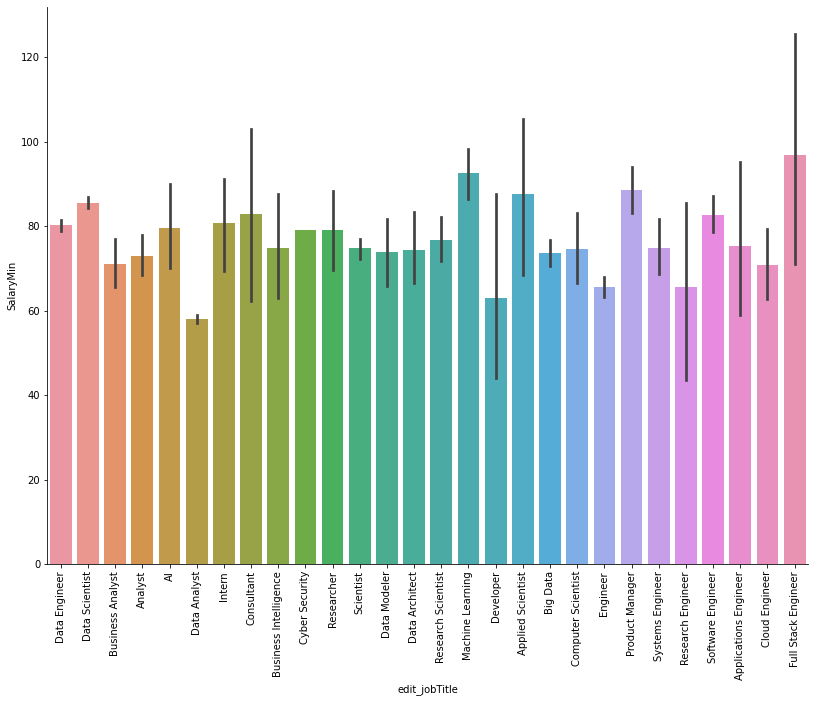

In [26]:
#plot salary info
import seaborn as sns

uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))
# sns.set(rc={'figure.figsize':(30,10)})
mini =sns.catplot(x="edit_jobTitle",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
mini.set_xticklabels(rotation=90)
#plt.legend(labels=uniqueJobTitles);

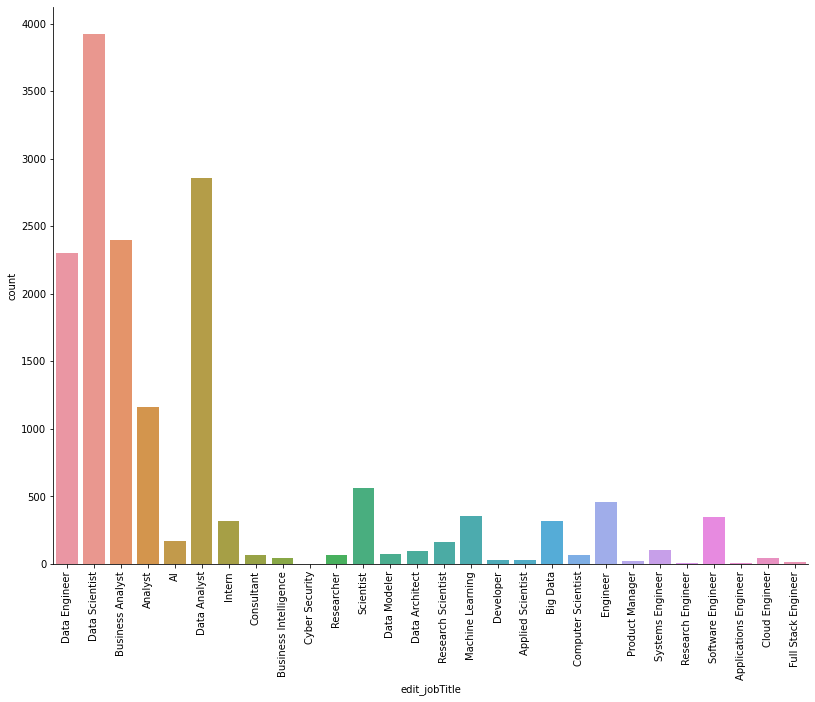

In [39]:
titles =sns.catplot(x="edit_jobTitle",kind="count", data=FDSword, height=8.27, aspect=11.7/8.27 )
titles.set_xticklabels(rotation=90);

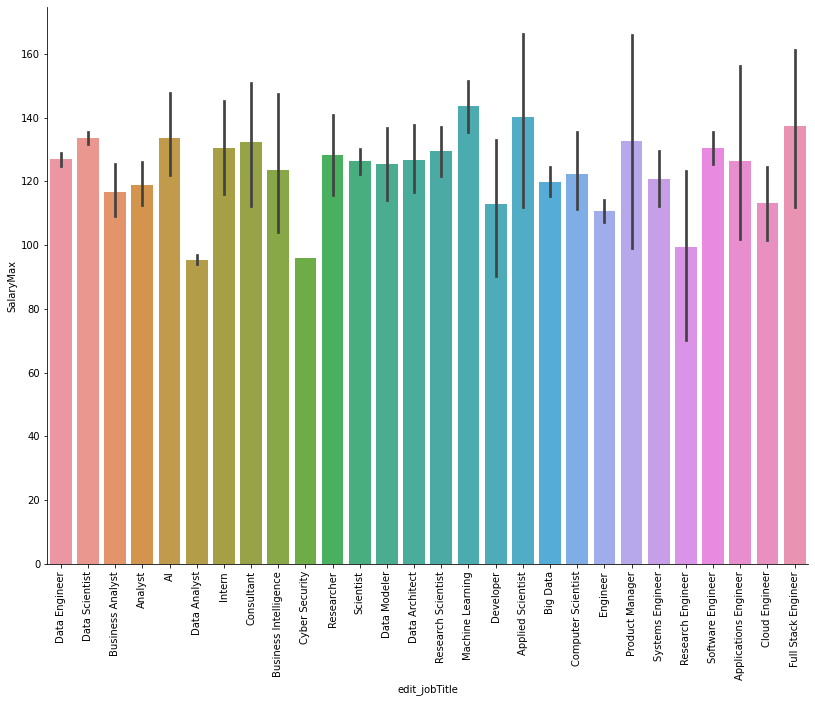

In [27]:
maxi =sns.catplot(x="edit_jobTitle",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxi.set_xticklabels(rotation=90);

In [28]:
#fix state info
def state(x):
    if x=="Florida":
        x="FL"
    if x==' CO':
        x="CO"
    if x==" NM":
        x="NM"
    if x==" CA":
        x="CA"
    if x==" NY":
        x="NY"
    if x==" WA":
        x="WA"
    if x==" UT":
        x="UT"
    if x==" TX":
        x="TX"        
    if x==" FL":
        x="FL"
    else:
        x=x
    return x
        
FDSword['State']=FDSword['State'].apply(lambda x: state(x))
#FullDataSet['State']=FullDataSet['State'].apply(lambda x: state(x))

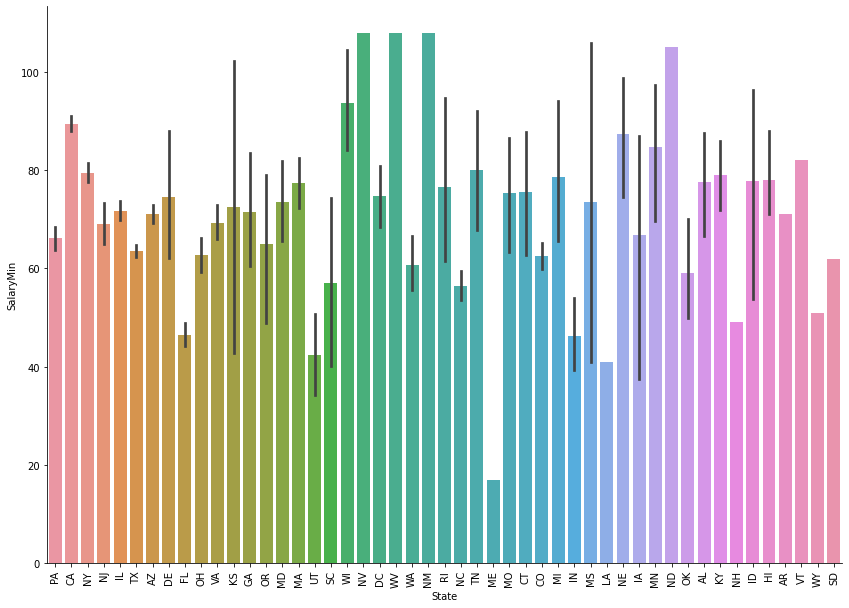

In [29]:
miniState =sns.catplot(x="State",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
miniState.set_xticklabels(rotation=90);

In [30]:
uniqueState=FDSword.State.unique()
print((uniqueState))
print((len(uniqueState)))

['PA' 'CA' 'NY' 'NJ' 'IL' 'TX' 'AZ' 'DE' 'FL' 'OH' 'VA' 'KS' 'GA' 'OR'
 'MD' 'MA' 'UT' 'SC' 'WI' 'NV' 'DC' 'WV' 'WA' 'NM' 'RI' 'NC' 'TN' 'ME'
 'MO' 'CT' 'CO' 'MI' nan 'IN' 'MS' 'LA' 'NE' 'IA' 'MN' 'ND' 'OK' 'AL' 'KY'
 'NH' 'ID' 'HI' 'AR' 'VT' 'WY' 'SD']
50


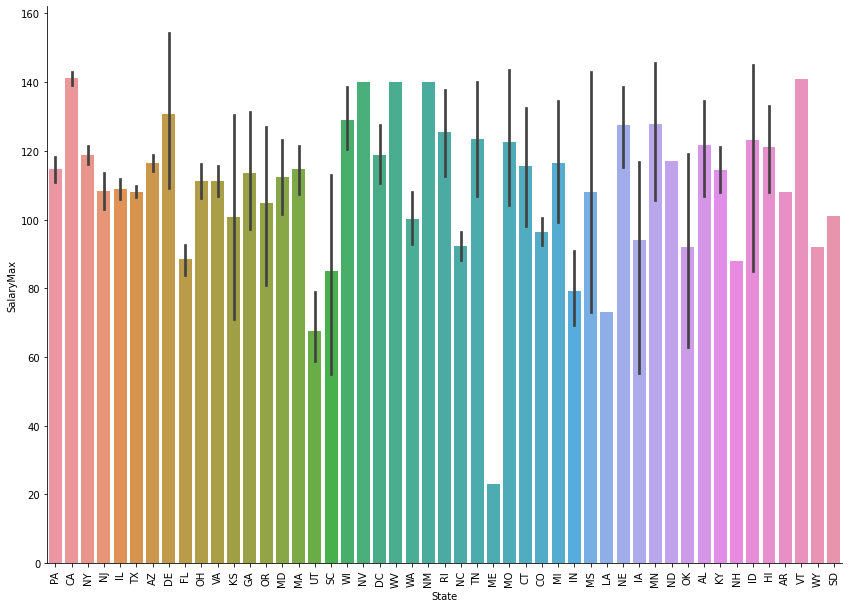

In [31]:
maxiState =sns.catplot(x="State",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxiState.set_xticklabels(rotation=90);

In [32]:
!curl -O https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87688  100 87688    0     0   120k      0 --:--:-- --:--:-- --:--:--  120k


In [33]:
#FDSstate=
FDSstate=FDSword.groupby(['State']).mean()
FDSstate['State']=FDSstate.index
#send df to a csv file
FDSstate.to_csv('FDSstate.csv')
FDSstate

Founded    Rating   SalaryMin   SalaryMax  Salary Estimate  \
State                                                                   
AL     1986.090909  3.746667   77.500000  121.562500              NaN   
AR             NaN       NaN   71.000000  108.000000              NaN   
AZ     1973.177391  3.770299   70.981941  116.485327        65.306667   
CA     1987.024522  3.844994   89.505104  141.197071        94.832597   
CO     1981.350515  3.759667   62.455285   96.325203              NaN   
CT     1982.800000  3.480000   75.533333  115.733333              NaN   
DC     1982.081081  3.815909   74.652174  118.739130              NaN   
DE     1935.367347  3.863492   74.457143  130.685714        73.882353   
FL     1972.187097  3.824365   46.397260   88.529680              NaN   
GA     1989.411765  3.910000   71.550000  113.500000              NaN   
HI     1999.500000  4.000000   78.000000  121.000000              NaN   
IA     1938.000000  4.040000   66.800000   94.000000              NaN   
ID     1991.833333  3.933333   77.857143  123.285714              NaN   
IL     1979.012414  3.727660   71.689382  108.808241        77.501706   
IN     1987.888889  3.736364   46.151515   79.212121              NaN   
KS     2003.000000  3.480000   72.500000  100.833333              NaN   
KY     1966.000000  3.500000   79.000000  114.500000              NaN   
LA     1999.000000  3.500000   41.000000   73.000000              NaN   
MA     1980.198113  3.963793   77.453782  114.798319              NaN   
MD     1974.884615  3.994643   73.526316  112.403509              NaN   
ME     1994.000000  4.200000   17.000000   23.000000              NaN   
MI     1978.750000  4.038889   78.611111  116.555556              NaN   
MN     1991.000000  3.885714   84.714286  127.785714              NaN   
MO     1965.041667  4.120000   75.440000  122.680000              NaN   
MS     1996.000000  3.400000   73.500000  108.000000              NaN   
NC     1972.836957  3.752381   56.504132   92.314050              NaN   
ND     1998.000000  3.800000  105.000000  117.000000              NaN   
NE     1928.000000  3.575000   87.333333  127.500000              NaN   
NH     2003.000000  4.100000   49.000000   88.000000              NaN   
NJ     1960.781609  3.682488   69.006211  108.304348        82.361446   
NM     1995.000000  4.400000  108.000000  140.000000              NaN   
NV     1993.000000  3.900000  108.000000  140.000000              NaN   
NY     1977.884663  3.801053   79.530355  118.910653        85.788618   
OH     1943.502890  3.805263   62.683258  111.153846              NaN   
OK     2002.666667  3.433333   59.000000   92.000000              NaN   
OR     1976.500000  3.988889   64.900000  104.900000              NaN   
PA     1963.968864  3.703443   66.120623  114.632296        81.965021   
RI     1967.200000  3.620000   76.600000  125.400000              NaN   
SC     1960.000000  3.428571   57.000000   85.000000              NaN   
SD             NaN       NaN   62.000000  101.000000              NaN   
TN     1953.684211  3.757895   80.052632  123.473684              NaN   
TX     1975.293612  3.742487   63.574928  108.108549        66.064243   
UT     1986.121212  3.882313   42.425532   67.638298              NaN   
VA     1981.550898  3.881443   69.274510  111.127451              NaN   
VT     2016.000000  4.800000   82.000000  141.000000              NaN   
WA     1987.378378  3.784122   60.767677  100.210000              NaN   
WI     1942.357143  3.826667   93.600000  128.933333              NaN   
WV     1996.000000  4.000000  108.000000  140.000000              NaN   
WY             NaN  4.100000   51.000000   92.000000              NaN   

         Hourly    Junior    Senior    remote  part-time      temp  sen  jun  \
State                                                                          
AL     0.000000       NaN  1.000000  0.062500   0.000000  0.000000  1.0  NaN   
AR     0.000000       NaN  1.000000  0.000000  

In [34]:
state_geo = 'us-states.json'

# state_min = FDSword.SalaryMin


m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'SalaryMin'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Min Salary'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [35]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'SalaryMax'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Max Salary'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [36]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'Rating'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Rating'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
!curl -O https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json

In [ ]:
# #FDScity=
# FDScity=FDSword.groupby(['City']).mean()
# FDScity['City']=FDSstate.index
# #send df to a csv file
# FDScity.to_csv('FDScity.csv')
# FDScity

In [37]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Redmond              115
Menlo Park           115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Tampa                 84
Redwood City          84
Charlotte             84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Santa Monica          58
Jersey City           58
Miami                 56
San Mateo             53
Chandler              51
Arlington             51
Glendale              50
Brooklyn              49
Santa Clara Valley    48
Cambridge             48
Fremont               47

In [38]:
#Bring in cost of living data
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-38-4d411242d9bc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-38-4d411242d9bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-38-4d411242d9bc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  